# SC Mass Balance Method

### pip install dataretrieval

In [1]:
# !pip install modvis
# pip install hydroeval
#!pip install baseflow

In [2]:
import h5py
import baseflow
from modvis import ATSutils
from modvis import utils
from modvis import general_plots as gp
import pandas as pd
import numpy as np
from dataretrieval import nwis
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from scipy import stats


from scipy.optimize import curve_fit
from scipy.stats import linregress
import h5py
import sys, os
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from tqdm import tqdm
from pathlib import Path
from baseflow.methods import *
from baseflow.comparision import strict_baseflow, KGE
from baseflow.utils import clean_streamflow, exist_ice, geo2imagexy, format_method
from baseflow.param_estimate import recession_coefficient, param_calibrate, maxmium_BFI

surf_area = 53159325.46184719 # in square meters
area = 20.3 #square miles

## Numerical model results and baseflow calculations: 

## Reading 'base_calibrated-wb-2014_2022-GW.csv'

In [3]:
df = pd.read_csv(os.path.join('base_calibrated-wb-2014_2022-GW.csv'), comment='#')

df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'] >= '10-01-2015']


## convert data to cms and plot it

In [4]:
df['watershed boundary discharge [m3 s^-1]'] = df['watershed boundary discharge [mol d^-1]']/55500/24/60/60

df['exfiltration [m3 s^-1]'] = df['exfiltration [mol d^-1]']/55500/24/60/60

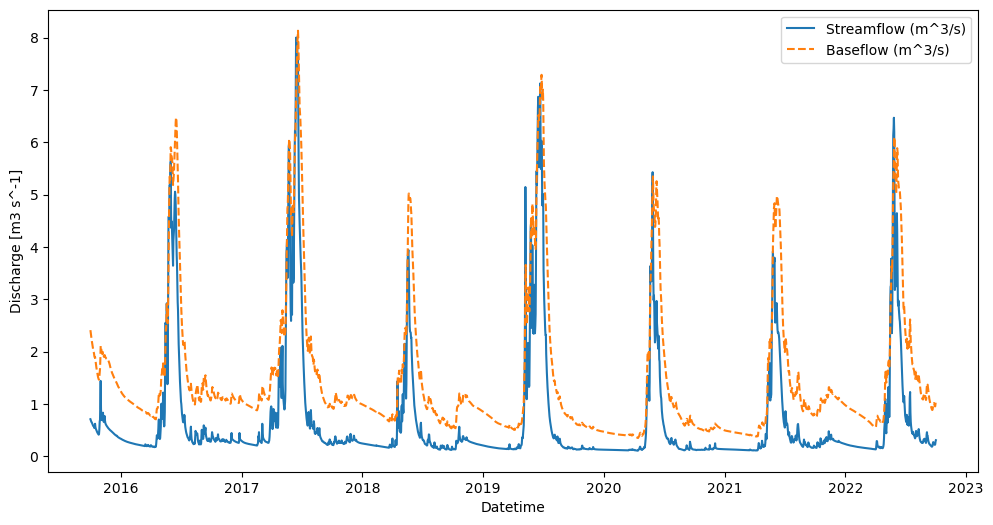

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(df['datetime'], df['watershed boundary discharge [m3 s^-1]'], label='Streamflow (m^3/s)')
plt.plot(df['datetime'], df['exfiltration [m3 s^-1]'], label='Baseflow (m^3/s)', linestyle='--')

# Adding labels and title
plt.xlabel('Datetime')
plt.ylabel('Discharge [m3 s^-1]')

# Adding legend
plt.legend()
plt.savefig('original_baseflow_numerical_method.png', dpi = 600)
plt.show()

#### The total exfiltration in the figure above is higher than the baseflow because of the re-exfiltration

In [6]:
## First, prove that there is reinfiltration causing a reexfiltration: plot the exfiltration and infiltration. If the infiltration in the dry season is not zero, there is reinfiltration. We assume it to be the exfiltration. 
### Assume that the infiltration is zero when rainfall and snowmelt are zero. filter the rows that apply these conditions and assume that the baseflow is equal to water content change - transpiration. Plot the baseflow of the dry period

In [7]:
df['infiltration [m d^-1]'] =  df['infiltration [mol d^-1]']/55500./surf_area
df['net runoff [m d^-1]'] = df['net runoff [mol d^-1]']/55500./surf_area
df['subsurface water content [m]'] = df['subsurface water content [mol]'] / 55500 / surf_area
df['subsurface water content change [m d^-1]'] = df['subsurface water content [m]'].diff()



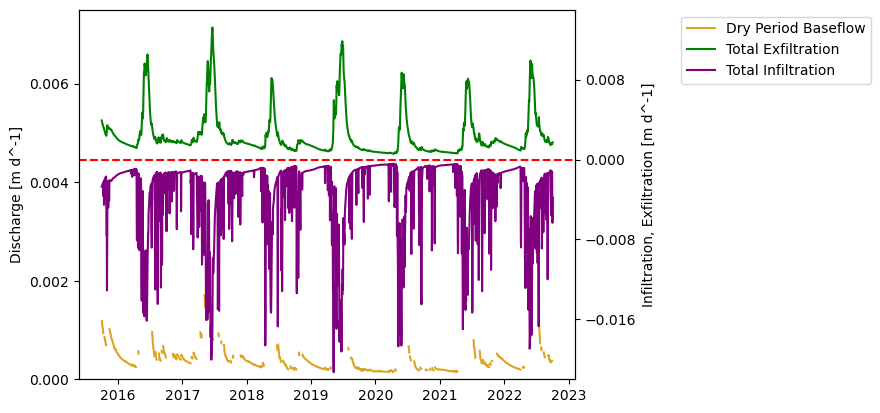

In [8]:
df['GW_discharge [m d^-1]'] =  -df['subsurface water content change [m d^-1]'] - df['transpiration [m d^-1]']
df['GW_discharge_new_dryperiod [m d^-1]'] = df.apply(
    lambda row: row['GW_discharge [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)



fig, ax1 = plt.subplots()
# ax1.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow (m/d)')
ax1.plot(df['datetime'], df['GW_discharge_new_dryperiod [m d^-1]'], label = 'Dry Period Baseflow', color='#DAA520')
ax1.set_ylabel('Discharge [m d^-1]')
ax1.set_ylim(0, 0.00750)
ax1.set_yticks(np.arange(0, 0.00750, 0.005))

ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))

ax2 = ax1.twinx()
ax2.plot(df['datetime'], df['exfiltration [m d^-1]'], label='Total Exfiltration', color = 'green')
ax2.plot(df['datetime'], df['infiltration [m d^-1]'], label='Total Infiltration', color = 'purple')
# ax2.plot(df['datetime'], df['net exchange flux [mol d^-1]']/55500/surf_area, label='Net Groundwater Flux')
ax2.set_ylabel('Infiltration, Exfiltration [m d^-1]')
ax2.set_ylim(-0.022, 0.015)
ax2.set_yticks(np.arange(-0.02, 0.02, 0.01))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))
# ax2.invert_yaxis()
ax2.axhline(y=0, color='red', linestyle='--')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.2, 1))

plt.savefig('reinfiltration_proof',dpi = 800, bbox_inches='tight')
plt.show()

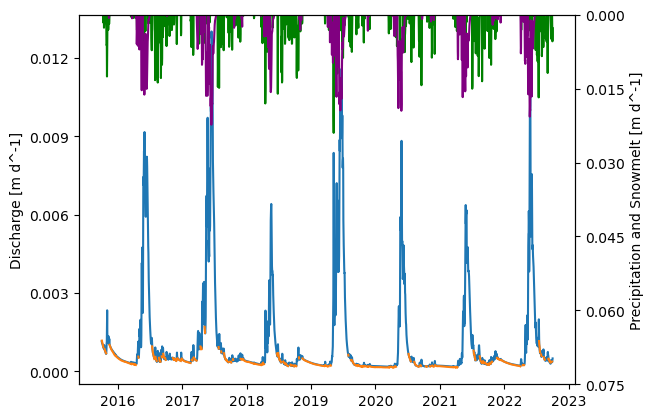

In [9]:
df['GW_discharge [m d^-1]'] =  -df['subsurface water content change [m d^-1]'] - df['transpiration [m d^-1]']
df['GW_discharge_new_dryperiod [m d^-1]'] = df.apply(
    lambda row: row['GW_discharge [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)



fig, ax1 = plt.subplots()
ax1.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow (m/d)')
ax1.plot(df['datetime'], df['GW_discharge_new_dryperiod [m d^-1]'], label = 'Baseflow (m/d)')
ax1.set_ylabel('Discharge [m d^-1]')
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax2 = ax1.twinx()
ax2.plot(df['datetime'], df['rain precipitation [m d^-1]'], label='Rain Precipitation (m/d)', color = 'green')
ax2.plot(df['datetime'], df['snowmelt [m d^-1]'], label='Snowmelt (m/d)', color = 'purple')
ax2.set_ylabel('Precipitation and Snowmelt [m d^-1]')
ax2.set_ylim(0, 0.075)
ax2.set_yticks(np.arange(0, 0.080, 0.005))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax2.invert_yaxis()


plt.savefig('Baseflow_dry_period',dpi = 800, bbox_inches='tight')
plt.show()

## calculation of reinfiltration of the dry season: rainfall and snowmelt are null, meaning no infiltration:

In [10]:
# df['reinfiltration [m d^-1]'] =  -df['subsurface water content change [m d^-1]'] - df['transpiration [m d^-1]']
df['reinfiltration_new_dryperiod [m d^-1]'] = df.apply(
    lambda row: row['exfiltration [m d^-1]'] - row['GW_discharge_new_dryperiod [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)

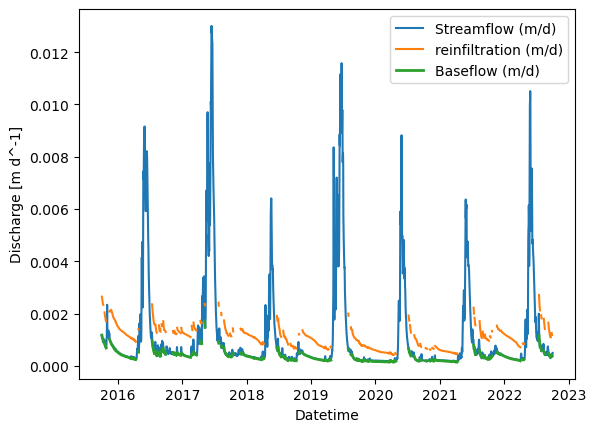

In [11]:
plt.figure()
plt.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow (m/d)')
plt.plot(df['datetime'], df['reinfiltration_new_dryperiod [m d^-1]'], label='reinfiltration (m/d)')
plt.plot(df['datetime'], df['GW_discharge_new_dryperiod [m d^-1]'], label='Baseflow (m/d)', linewidth=2)
plt.xlabel('Datetime')
plt.ylabel('Discharge [m d^-1]')
plt.legend()
plt.show()

In [12]:
## find the relationship between reinfiltration and streamflow. Use this relationship to find the continuous reinfiltration and then plot baseflow = exfiltration - reinfiltration## find the relationship between reinfiltration and streamflow. Use this relationship to find the continuous reinfiltration and then plot baseflow = exfiltration - reinfiltration

#### linear relationship

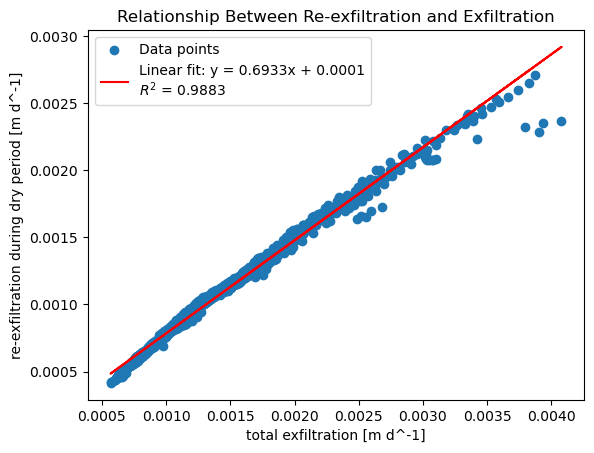

In [13]:
filtered_df = df.dropna(subset=['reinfiltration_new_dryperiod [m d^-1]'])

x = filtered_df['exfiltration [m d^-1]']
y = filtered_df['reinfiltration_new_dryperiod [m d^-1]']


plt.figure()
plt.scatter(x, y, label='Data points')
plt.xlabel('total exfiltration [m d^-1]')
plt.ylabel('re-exfiltration during dry period [m d^-1]')

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.plot(x, slope * x + intercept, color='red', label=f'Linear fit: y = {slope:.4f}x + {intercept:.4f}\n$R^2$ = {r_value**2:.4f}')

plt.legend()
plt.title('Relationship Between Re-exfiltration and Exfiltration')
plt.savefig('Relationship Between Re-exfiltration and Exfiltration',dpi = 800)
plt.show()



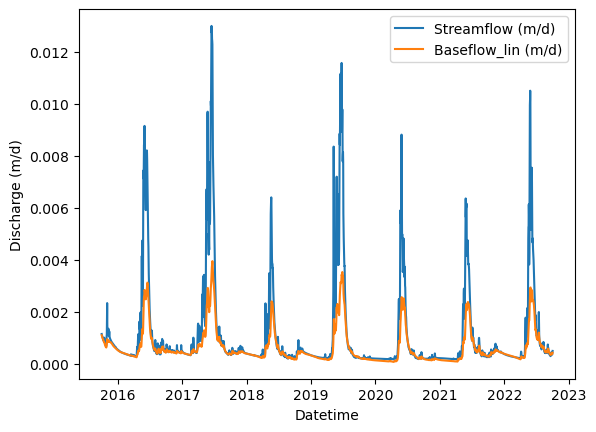

In [14]:
df['daily_reinfiltration_lin [m d^-1]'] = 0.6933 * df['exfiltration [m d^-1]'] + 0.0001
df['baseflow_lin [m d^-1]'] = df['exfiltration [m d^-1]'] - df['daily_reinfiltration_lin [m d^-1]']

plt.figure()
plt.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow (m/d)')
plt.plot(df['datetime'], df['baseflow_lin [m d^-1]'], label='Baseflow_lin (m/d)')
plt.xlabel('Datetime')
plt.ylabel('Discharge (m/d)')
plt.legend()
plt.show()

#### checking if there are days of baseflow greater than streamflow
#### find the average exceedance
#### find the exceedance days per each month of each year and the average exceedance

In [15]:
df['baseflow_greater_than_runoff'] = df['baseflow_lin [m d^-1]'] > df['net runoff [m d^-1]']
df['exceedance'] = df['baseflow_lin [m d^-1]'] - df['net runoff [m d^-1]']
df['percentage_exceedance'] = (df['exceedance'] / df['net runoff [m d^-1]']) * 100

exceedance_df = df[df['baseflow_greater_than_runoff']]

dates_with_condition = exceedance_df[['datetime', 'percentage_exceedance']]

dates_with_condition.to_csv('baseflow_greater_streamflow_new.csv')

# dates_with_condition = df[df['baseflow_greater_than_runoff']]['datetime']
dates_with_condition
# dates_with_condition.to_csv('baseflow_greater_streamflow.csv')

,datetime,percentage_exceedance
482,2016-01-26,0.077089
483,2016-01-27,0.195222
484,2016-01-28,0.382629
485,2016-01-29,0.568523
486,2016-01-30,0.769178
...,...,...
2915,2022-09-26,5.650971
2916,2022-09-27,7.151679
2917,2022-09-28,6.111241
2918,2022-09-29,6.762267


In [16]:
overall_percentage_exceedance = exceedance_df['percentage_exceedance'].mean()
overall_percentage_exceedance

6.508891466766489

In [17]:
exceedance_df['year_month'] = exceedance_df['datetime'].dt.to_period('M')
grouped = exceedance_df.groupby('year_month').agg(
    days_of_exceedance=('percentage_exceedance', 'size'),
    average_exceedance=('percentage_exceedance', 'mean')
).reset_index()
grouped

C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\2192872369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exceedance_df['year_month'] = exceedance_df['datetime'].dt.to_period('M')


,year_month,days_of_exceedance,average_exceedance
0,2016-01,6,0.494491
1,2016-02,29,1.930365
2,2016-03,14,1.770707
3,2016-07,12,4.385142
4,2016-08,18,9.143328
5,2016-09,2,1.914288
6,2016-10,1,1.621994
7,2017-01,11,0.771714
8,2017-02,20,1.757307
9,2017-03,15,4.348657


In [18]:
exceedance_df['month'] = exceedance_df['datetime'].dt.month

grouped_monthly = exceedance_df.groupby('month').agg(
    days_of_exceedance=('percentage_exceedance', 'size'),
    average_exceedance=('percentage_exceedance', 'mean'),
    min_exceedance=('percentage_exceedance', 'min'),
    max_exceedance=('percentage_exceedance', 'max'),
    stddev_exceedance=('percentage_exceedance', 'std')
).reset_index()

# grouped_monthly.to_csv('monthly_exceedance_stats_overall.csv')
grouped_monthly

C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\3739875032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exceedance_df['month'] = exceedance_df['datetime'].dt.month


,month,days_of_exceedance,average_exceedance,min_exceedance,max_exceedance,stddev_exceedance
0,1,67,2.878652,0.034627,7.161801,2.600682
1,2,87,2.890047,0.026023,7.173408,2.006428
2,3,36,2.747454,0.228552,6.089564,1.800349
3,6,9,6.507989,0.266587,9.738908,2.767348
4,7,88,7.359262,0.236338,23.918955,5.625061
5,8,115,10.961142,0.001310,29.853322,6.494202
6,9,100,9.059206,0.156472,24.072435,6.435455
7,10,33,6.076839,0.214422,16.814227,4.579696
8,11,2,1.379324,0.756540,2.002109,0.880751
9,12,23,1.123214,0.012133,2.692765,0.945425


In [19]:
df['final_baseflow [m d^-1]'] = np.where(
    df['baseflow_greater_than_runoff'] & df['reinfiltration_new_dryperiod [m d^-1]'].notna(),
    df['GW_discharge_new_dryperiod [m d^-1]'],
    df['baseflow_lin [m d^-1]']
)

In [20]:
df['baseflow_greater_than_runoff_final'] = df['final_baseflow [m d^-1]'] > df['net runoff [m d^-1]']
dates_with_condition_final = df[df['baseflow_greater_than_runoff_final']]['datetime']
dates_with_condition_final

654    2016-07-16
655    2016-07-17
656    2016-07-18
657    2016-07-19
658    2016-07-20
          ...    
2911   2022-09-22
2915   2022-09-26
2917   2022-09-28
2918   2022-09-29
2919   2022-09-30
Name: datetime, Length: 284, dtype: datetime64[ns]

In [21]:
#### setting the rows that still have baseflow greater than streamflow to NaN

In [22]:
df.loc[df['baseflow_greater_than_runoff_final'], 'final_baseflow [m d^-1]'] = np.nan

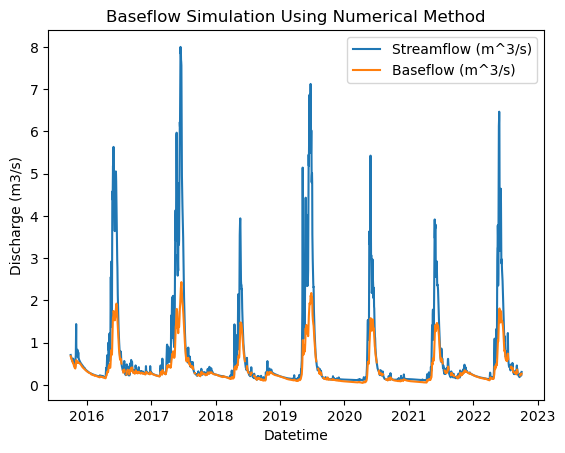

In [23]:
df['net runoff [m3 s^-1]'] = df['net runoff [m d^-1]'] * surf_area/24/60/60
df['final_baseflow [m3 s^-1]'] = df['final_baseflow [m d^-1]'] * surf_area/24/60/60

plt.figure()
plt.plot(df['datetime'], df['net runoff [m3 s^-1]'], label='Streamflow (m^3/s)')
plt.plot(df['datetime'], df['final_baseflow [m3 s^-1]'], label='Baseflow (m^3/s)')
plt.xlabel('Datetime')
plt.ylabel('Discharge (m3/s)')
plt.legend()
plt.title('Baseflow Simulation Using Numerical Method')
plt.savefig('final_baseflow_numerical_method', dpi = 800)
plt.show()

In [24]:
df.to_csv('numerical_method_baseflow.csv')

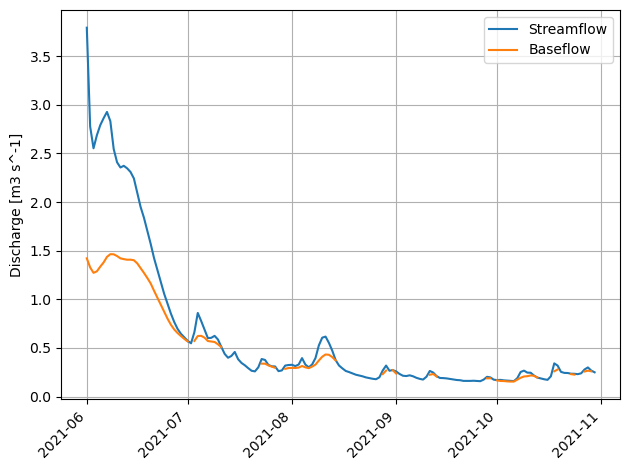

In [25]:
startdate = '2021-06-01'
enddate = '2021-10-30'
filtereddf = df[(df['datetime'] >= startdate) & (df['datetime'] <= enddate)]

plt.figure()
plt.plot(filtereddf['datetime'], filtereddf['net runoff [m3 s^-1]'], label='Streamflow')
plt.plot(filtereddf['datetime'], filtereddf['final_baseflow [m3 s^-1]'], label='Baseflow')
# plt.plot(filtered_df['datetime'], filtered_df['exfiltration [m d^-1]'], label='Exfiltration')

# plt.plot(filtered_df['datetime'], filtered_df['baseflow_lin [m d^-1]'], label='Estimated Baseflow', color='red')

plt.ylabel('Discharge [m3 s^-1]')
# plt.title('Discharge from October 2017 to October 2018')
plt.legend()
# plt.ylim(0, 0.003)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('final baseflow_Jul2021_to_Mar2021.png', dpi=300)
plt.show()


In [26]:
## Applying recession analysis to find the recession constant: 

In [27]:
df['decreasing_gw'] = df['GW_discharge_new_dryperiod [m d^-1]'].diff().lt(0).astype(int)
df['not_nan'] = df['GW_discharge_new_dryperiod [m d^-1]'].notna().astype(int)

In [28]:
df['decreasing_gw'] = df['decreasing_gw'] * df['not_nan']

In [29]:
df['decreasing_gw_streak'] = df['decreasing_gw'] * (df['decreasing_gw'].groupby((df['decreasing_gw'] != df['decreasing_gw'].shift()).cumsum()).cumcount() + 1)


In [30]:
five_day_decrease_gw_periods = df[df['decreasing_gw_streak'] >= 5]
five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)
filtered_gw_df = five_day_decrease_gw_periods.dropna(subset=['Qt', 'Qt_plus_1'])

C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\4005746316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\4005746316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)


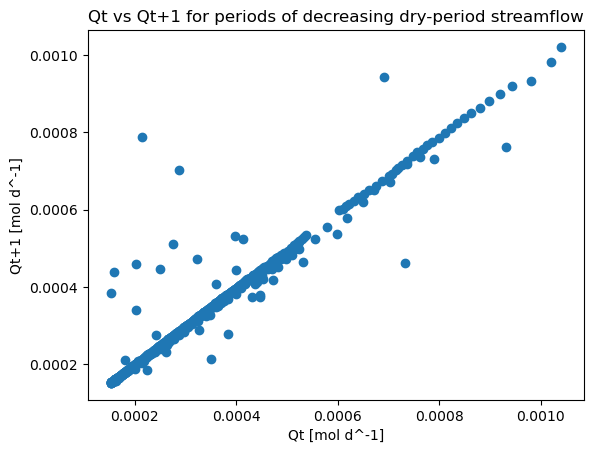

In [31]:
plt.scatter(filtered_gw_df['Qt'], filtered_gw_df['Qt_plus_1'])
plt.xlabel('Qt [mol d^-1]')
plt.ylabel('Qt+1 [mol d^-1]')
plt.title('Qt vs Qt+1 for periods of decreasing dry-period streamflow')
plt.savefig('recession analysis', dpi=1000)
plt.show()

In [32]:
X_gw = filtered_gw_df['Qt'].values.reshape(-1, 1)
y_gw = filtered_gw_df['Qt_plus_1'].values
reg_gw = LinearRegression(fit_intercept=False)
reg_gw.fit(X_gw, y_gw)
recession_constant_a_gw = reg_gw.coef_[0]
recession_constant_a_gw

0.9881641114040819

In [33]:

reg_gw = LinearRegression(fit_intercept=False)
reg_gw.fit(X_gw, y_gw)
recession_constant_a_gw = reg_gw.coef_[0]
recession_constant_a_gw

0.9881641114040819

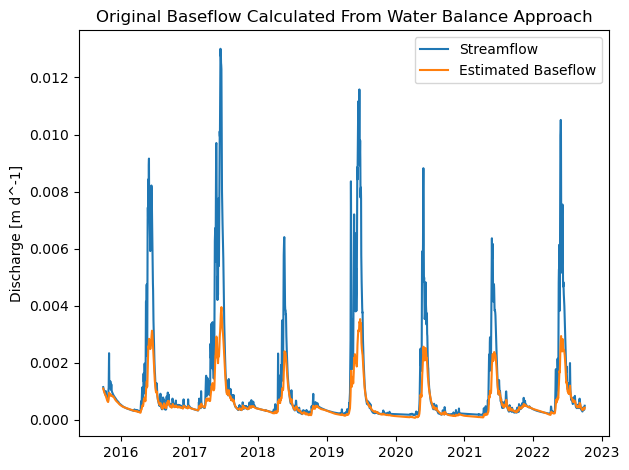

In [34]:
# start_date = '2020-10-01'
# end_date = '2021-10-01'
# filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

plt.figure()
plt.plot(df['datetime'], df['net runoff [m d^-1]'], label='Streamflow')
# plt.plot(df['datetime'], df['GW_discharge_new_dryperiod [m d^-1]'], label='Dry Period Baseflow', color = 'black')
# plt.plot(filtered_df['datetime'], filtered_df['exfiltration [m d^-1]'], label='Exfiltration')

plt.plot(df['datetime'], df['baseflow_lin [m d^-1]'], label='Estimated Baseflow')

plt.ylabel('Discharge [m d^-1]')
plt.title('Original Baseflow Calculated From Water Balance Approach')
plt.legend()


plt.tight_layout()
plt.savefig('original cont baseflow.png', dpi=300)
plt.show()


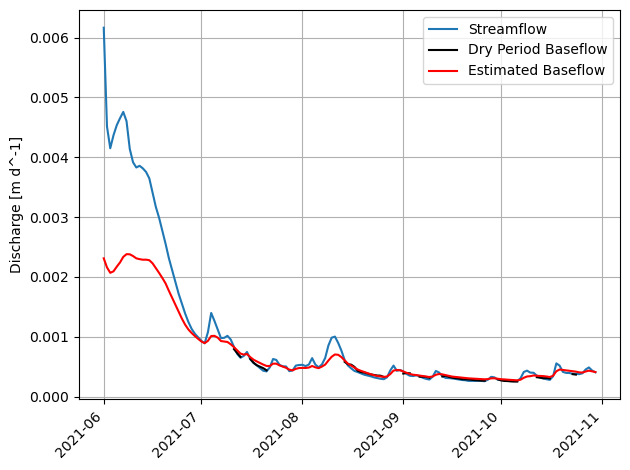

In [35]:

start_date = '2021-06-01'
end_date = '2021-10-30'
filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

plt.figure()
plt.plot(filtered_df['datetime'], filtered_df['net runoff [m d^-1]'], label='Streamflow')
plt.plot(filtered_df['datetime'], filtered_df['GW_discharge_new_dryperiod [m d^-1]'], label='Dry Period Baseflow', color = 'black')
# plt.plot(filtered_df['datetime'], filtered_df['exfiltration [m d^-1]'], label='Exfiltration')

plt.plot(filtered_df['datetime'], filtered_df['baseflow_lin [m d^-1]'], label='Estimated Baseflow', color='red')

plt.ylabel('Discharge [m d^-1]')
# plt.title('Discharge from October 2017 to October 2018')
plt.legend()
# plt.ylim(0, 0.003)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Discharge_Jul2021_to_Mar2021.png', dpi=300)
plt.show()


# Plotting observed streamflow

In [36]:
obs_df = utils.load_nwis(sites= "09111250", start = '2015-10-01', end = '2022-10-01')

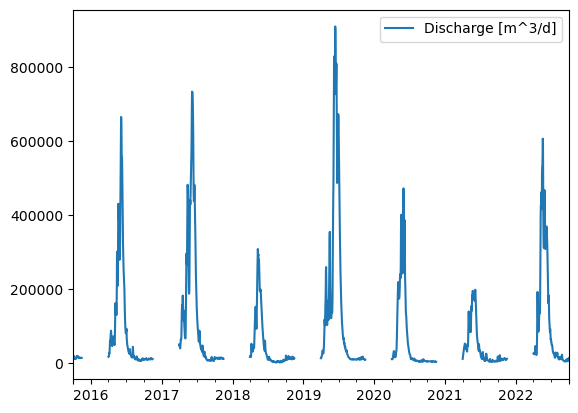

In [37]:
obs_df.plot()
plt.savefig('discontinuous_discharge.png')

### Retrieving the specific conductivity data for '09111250 coal creek wattershed'

In [38]:
#retrieving Specific Conductivity data for Coal Creek


# Inputs for site, variable, and date range
site = '09111250'  # for Coal Creek
pcode = '00095'    # for specific conductivity
startdate = '1990-01-01'
enddate = '2024-02-07'

# Retrieve data 
SC = nwis.get_qwdata(sites=site,
                 parameterCd=pcode,
                 startDt=startdate,
                 endDt=enddate)

### Merging the specific conductivity measurements to the dataframe of the daily discharge (simulated)

In [39]:
df = pd.read_csv(os.path.join('numerical_method_baseflow.csv'), comment='#')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df[df['datetime'] >= '10-01-2015']
df.set_index('datetime', inplace = True)

In [40]:
df_SC = SC[0][['p00095']]
daily_SC = df_SC.resample('D').mean()

In [41]:
df.index = df.index.tz_localize(None)
daily_SC.index = daily_SC.index.tz_localize(None)

In [42]:
merged_df = df.merge(daily_SC, how='left', left_index=True, right_index=True)

In [43]:
new_dataframe = merged_df[['watershed boundary discharge [m3 s^-1]', 'p00095']]

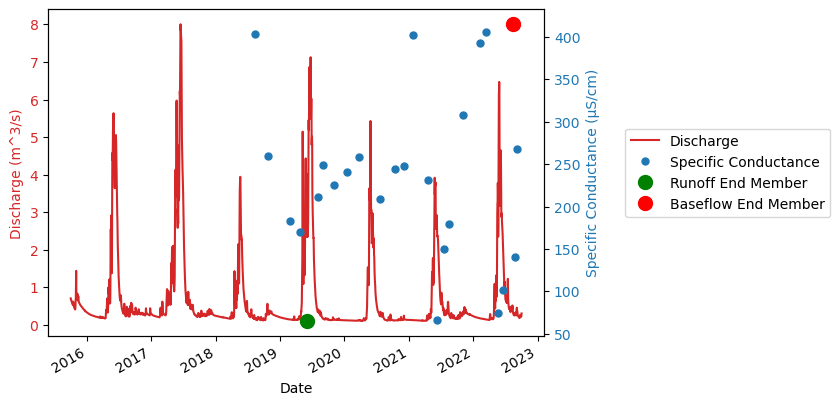

In [44]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (m^3/s)', color=color)
ax1.plot(new_dataframe.index, new_dataframe['watershed boundary discharge [m3 s^-1]'], color=color, label='Discharge')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for the specific conductivity
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Specific Conductance (µS/cm)', color=color)
ax2.plot(new_dataframe.index, new_dataframe['p00095'], marker='o', linestyle='None', markersize=5, color='tab:blue', label='Specific Conductance')
ax2.tick_params(axis='y', labelcolor=color)

# Find min and max values of p00095
min_val = new_dataframe['p00095'].min()
max_val = new_dataframe['p00095'].max()

# Get the corresponding dates for min and max values
min_date = new_dataframe['p00095'].idxmin()
max_date = new_dataframe['p00095'].idxmax()

# Plot min and max values with different colors
ax2.plot(min_date, min_val, 'go', markersize=10, label='Runoff End Member')
ax2.plot(max_date, max_val, 'ro', markersize=10, label='Baseflow End Member')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))

# Show the plot
# plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.savefig('SC_and_Discharge_data_new', dpi=1200)
plt.show()

In [45]:
new_dataframe['p00095'].replace(-999999, np.nan, inplace=True)


C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\1598594436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe['p00095'].replace(-999999, np.nan, inplace=True)


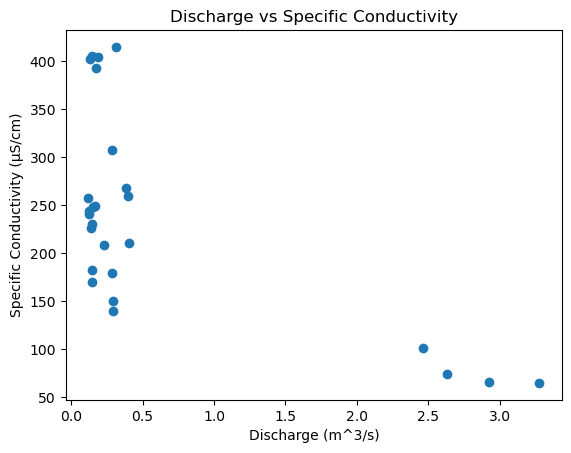

In [46]:
plt.scatter(new_dataframe['watershed boundary discharge [m3 s^-1]'], new_dataframe['p00095'])

plt.xlabel('Discharge (m^3/s)')
plt.ylabel('Specific Conductivity (µS/cm)')
plt.title('Discharge vs Specific Conductivity')
plt.grid(False)

plt.show()

## Interpolation of SC using power function with discharge obtained from ATS numerical model:

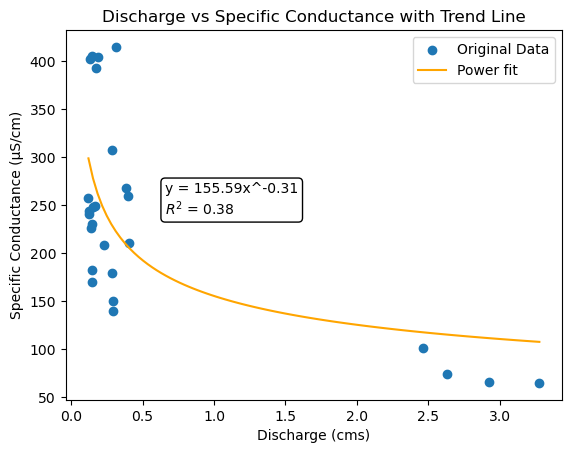

(None, array([155.58556927,  -0.30942039]), 0.3810677323229662)

In [47]:
cleaned_df_250 = new_dataframe.dropna(subset=['watershed boundary discharge [m3 s^-1]', 'p00095'])

x_cleaned = cleaned_df_250['watershed boundary discharge [m3 s^-1]'].values
y_cleaned = cleaned_df_250['p00095'].values

def power_func(x, a, b):
    return a * np.power(x, b)

# Curve fitting with cleaned data
popt_cleaned, pcov_cleaned = curve_fit(power_func, x_cleaned, y_cleaned)

# Generating values for the trend line with cleaned data
x_fit_cleaned = np.linspace(x_cleaned.min(), x_cleaned.max(), 100)
y_fit_cleaned = power_func(x_fit_cleaned, *popt_cleaned)

# Calculate R-squared with cleaned data
residuals_cleaned = y_cleaned - power_func(x_cleaned, *popt_cleaned)
ss_res_cleaned = np.sum(residuals_cleaned**2)
ss_tot_cleaned = np.sum((y_cleaned - np.mean(y_cleaned))**2)
r_squared_cleaned = 1 - (ss_res_cleaned / ss_tot_cleaned)

# Plotting with cleaned data
plt.scatter(x_cleaned, y_cleaned, label='Original Data')
plt.plot(x_fit_cleaned, y_fit_cleaned, color='orange', label='Power fit')

plt.xlabel('Discharge (cms)')
plt.ylabel('Specific Conductance (µS/cm)')
plt.title('Discharge vs Specific Conductance with Trend Line')
plt.grid(False)

# Annotating with the power function equation and R^2 with cleaned data
equation_text_cleaned = f'y = {popt_cleaned[0]:.2f}x^{popt_cleaned[1]:.2f}\n$R^2$ = {r_squared_cleaned:.2f}'
plt.annotate(equation_text_cleaned, xy=(0.2, 0.50), xycoords='axes fraction', 
             bbox=dict(boxstyle="round", fc="w"))

plt.legend()
plt.savefig('discharge_SC_relationship_new.png', dpi=800)
plt.show(), popt_cleaned, r_squared_cleaned


In [48]:
interpolated_SC = power_func(merged_df['watershed boundary discharge [m3 s^-1]'].values, *popt_cleaned)
merged_df['interpolated_SC_power'] = interpolated_SC

In [49]:
min_sc_index = new_dataframe['p00095'].idxmin()
ro_end_member_streamflow = new_dataframe.loc[min_sc_index, 'watershed boundary discharge [m3 s^-1]']
ro_end_member = new_dataframe['p00095'].min()

# Print the runoff end member streamflow and specific conductance
print(f'Runoff End Member (ro_end_member) Streamflow: {ro_end_member_streamflow} m^3/s')
print(f'Runoff End Member (ro_end_member) Specific Conductance: {ro_end_member} µS/cm')

Runoff End Member (ro_end_member) Streamflow: 3.276514165407073 m^3/s
Runoff End Member (ro_end_member) Specific Conductance: 65.0 µS/cm


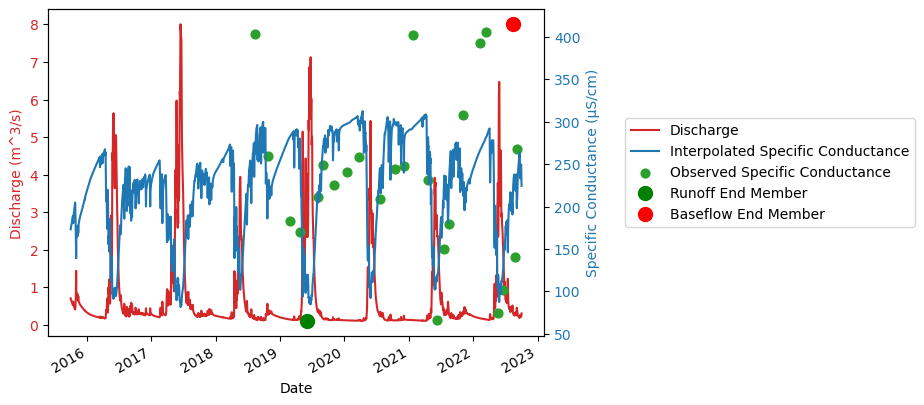

In [50]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (m^3/s)', color=color)
ax1.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], color=color, label='Discharge')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for the specific conductance
ax2 = ax1.twinx()

color_observed = 'tab:blue'
ax2.set_ylabel('Specific Conductance (µS/cm)', color=color_observed)
ax2.plot(merged_df.index, merged_df['interpolated_SC_power'], color='tab:blue', linestyle='-', label='Interpolated Specific Conductance')
ax2.scatter(cleaned_df_250.index, cleaned_df_250['p00095'], color='tab:green', label='Observed Specific Conductance', marker='o', s=40)
ax2.tick_params(axis='y', labelcolor=color_observed)

# Plot min and max values with different colors
ax2.plot(min_date, min_val, 'go', markersize=10, label='Runoff End Member')
ax2.plot(max_date, max_val, 'ro', markersize=10, label='Baseflow End Member')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5))
plt.savefig('interpolated SC.png', dpi=800)

plt.gcf().autofmt_xdate()
plt.show()

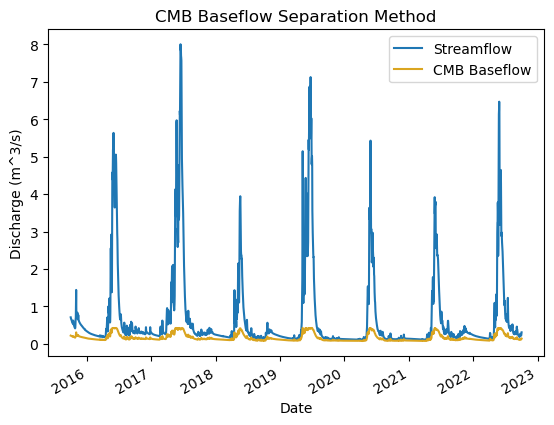

In [51]:
ro_end_member = new_dataframe['p00095'].min()
bf_end_member = new_dataframe['p00095'].max()

merged_df['MCB_baseflow_power'] = merged_df['watershed boundary discharge [m3 s^-1]'] * \
    ((merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member - ro_end_member))

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB_baseflow
ax.plot(merged_df.index, merged_df['MCB_baseflow_power'], label='CMB Baseflow', color='#DAA520')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m^3/s)')
ax.legend()
plt.gcf().autofmt_xdate()
plt.title('CMB Baseflow Separation Method')
plt.savefig('_CMB_baseflow.png', dpi=800)
plt.show()

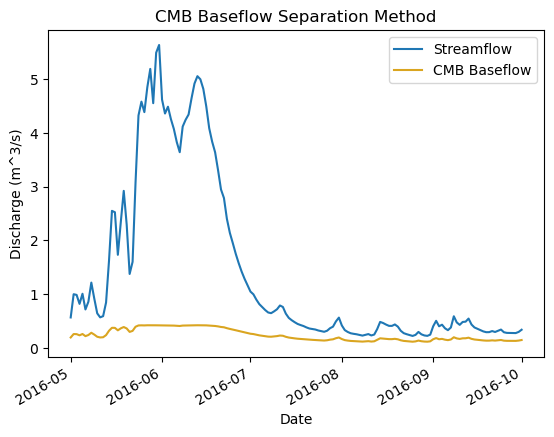

In [52]:
start_date = '2016-05-01'
end_date = '2016-10-01'
merged_df_zoom = merged_df.loc[start_date:end_date]

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df_zoom.index, merged_df_zoom['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB_baseflow
ax.plot(merged_df_zoom.index, merged_df_zoom['MCB_baseflow_power'], label='CMB Baseflow', color='#DAA520')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m^3/s)')
ax.legend()
plt.gcf().autofmt_xdate()
plt.title('CMB Baseflow Separation Method')
plt.savefig('zoom_CMB_baseflow.png', dpi=1200)
plt.show()

### Sensitivity test to find the impact of end members on the baseflow by changing end members by +-10%

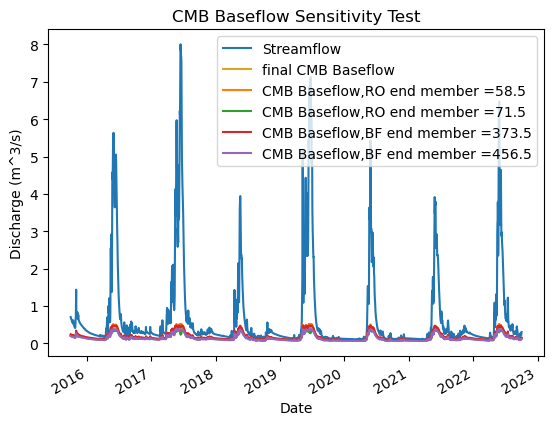

In [53]:
ro_end_member_75 = 71.5
bf_end_member = new_dataframe['p00095'].max()
merged_df['MCB_baseflow_power_75'] = merged_df['watershed boundary discharge [m3 s^-1]'] * \
    ((merged_df['interpolated_SC_power'] - ro_end_member_75) / (bf_end_member - ro_end_member_75))


ro_end_member_55 = 58.5
bf_end_member = new_dataframe['p00095'].max()
merged_df['MCB_baseflow_power_55'] = merged_df['watershed boundary discharge [m3 s^-1]'] * \
    ((merged_df['interpolated_SC_power'] - ro_end_member_55) / (bf_end_member - ro_end_member_55))


ro_end_member = new_dataframe['p00095'].min()
bf_end_member_375 = 373.5
merged_df['MCB_baseflow_power_375'] = merged_df['watershed boundary discharge [m3 s^-1]'] * \
    ((merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member_375 - ro_end_member))


ro_end_member = new_dataframe['p00095'].min()
bf_end_member_455 = 456.5
merged_df['MCB_baseflow_power_455'] = merged_df['watershed boundary discharge [m3 s^-1]'] * \
    ((merged_df['interpolated_SC_power'] - ro_end_member) / (bf_end_member_455 - ro_end_member))



fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df.index, merged_df['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB_baseflow
ax.plot(merged_df.index, merged_df['MCB_baseflow_power'], label='final CMB Baseflow', color='#DAA520')
ax.plot(merged_df.index, merged_df['MCB_baseflow_power_55'], label='CMB Baseflow,RO end member =58.5')
ax.plot(merged_df.index, merged_df['MCB_baseflow_power_75'], label='CMB Baseflow,RO end member =71.5')
ax.plot(merged_df.index, merged_df['MCB_baseflow_power_375'], label='CMB Baseflow,BF end member =373.5')
ax.plot(merged_df.index, merged_df['MCB_baseflow_power_455'], label='CMB Baseflow,BF end member =456.5')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m^3/s)')
ax.legend()
plt.gcf().autofmt_xdate()
plt.title('CMB Baseflow Sensitivity Test')
plt.savefig('sensitivity_test_CMB.png', dpi=1200)
plt.show()

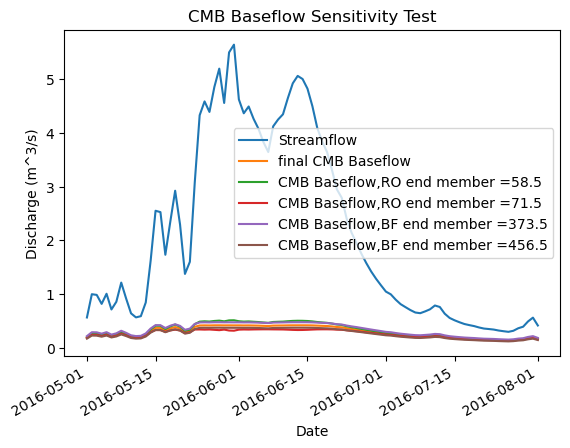

In [54]:
start_date = '2016-05-01'
end_date = '2016-08-01'
merged_df_zoom_test = merged_df.loc[start_date:end_date]

fig, ax = plt.subplots()

# Plot total discharge
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['watershed boundary discharge [m3 s^-1]'], label='Streamflow')

# Plot MCB_baseflow
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power'], label='final CMB Baseflow')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power_55'], label='CMB Baseflow,RO end member =58.5')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power_75'], label='CMB Baseflow,RO end member =71.5')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power_375'], label='CMB Baseflow,BF end member =373.5')
ax.plot(merged_df_zoom_test.index, merged_df_zoom_test['MCB_baseflow_power_455'], label='CMB Baseflow,BF end member =456.5')

ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m^3/s)')
ax.legend()
plt.gcf().autofmt_xdate()
plt.title('CMB Baseflow Sensitivity Test')
plt.savefig('sensitivity_test_CMB_zoom.png', dpi=1200)
plt.show()

# Plotting numerical Model Method baseflow

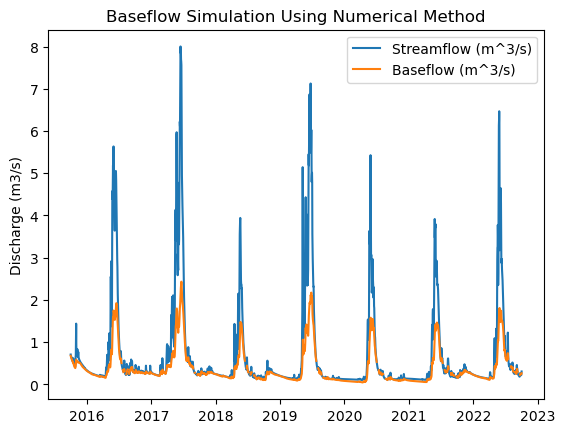

In [55]:
plt.figure()
plt.plot(df.index, df['net runoff [m3 s^-1]'], label='Streamflow (m^3/s)')
plt.plot(df.index, df['final_baseflow [m3 s^-1]'], label='Baseflow (m^3/s)')

plt.ylabel('Discharge (m3/s)')
plt.legend()
plt.title('Baseflow Simulation Using Numerical Method')
# plt.savefig('final_baseflow_numerical_method', dpi = 800)
plt.show()

In [56]:
start_date = '2017-10-01'
end_date = '2018-10-01'
df_zoom_ats = df.loc[start_date:end_date]

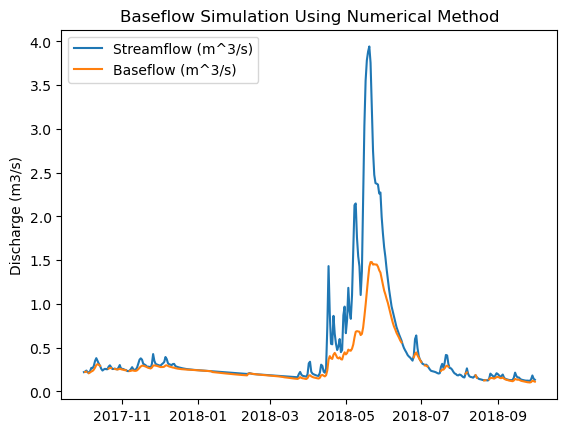

In [57]:
plt.figure()
plt.plot(df_zoom_ats.index, df_zoom_ats['net runoff [m3 s^-1]'], label='Streamflow (m^3/s)')
plt.plot(df_zoom_ats.index, df_zoom_ats['final_baseflow [m3 s^-1]'], label='Baseflow (m^3/s)')

plt.ylabel('Discharge (m3/s)')
plt.legend()
plt.title('Baseflow Simulation Using Numerical Method')
# plt.savefig('final_baseflow_numerical_method_wet_2018', dpi = 800)
plt.show()

## Calculating the average streamflow for the water year 2021 and that of the whole period to know if the streamflow of this year is below average or not: 

In [58]:
average_total_period = df['net runoff [m3 s^-1]'].mean()
average_total_period

0.6793733970196835

In [59]:
specific_period_df = df.loc['2020-10-01':'2021-10-01']
average_specific_period = specific_period_df['net runoff [m3 s^-1]'].mean()
average_specific_period

0.453899812514677

# Digital Filter Method

## calculating the recession constant using recession analysis:

In [60]:
df_digital = pd.read_csv(os.path.join('../numerical method/base_calibrated-wb-2014_2022-GW.csv'), comment='#')

df_digital['datetime'] = pd.to_datetime(df_digital['datetime'])
df_digital = df_digital[df_digital['datetime'] >= '10-01-2015']


In [61]:
df_digital['infiltration [m d^-1]'] =  df_digital['infiltration [mol d^-1]']/55500./surf_area
df_digital['net runoff [m d^-1]'] = df_digital['net runoff [mol d^-1]']/55500./surf_area
df_digital['subsurface water content [m]'] = df_digital['subsurface water content [mol]'] / 55500 / surf_area
df_digital['subsurface water content change [m d^-1]'] = df_digital['subsurface water content [m]'].diff()

In [62]:
df_digital['GW_discharge [m d^-1]'] =  -df_digital['subsurface water content change [m d^-1]'] - df_digital['transpiration [m d^-1]']
df_digital['GW_discharge_new_dryperiod [m d^-1]'] = df_digital.apply(
    lambda row: row['GW_discharge [m d^-1]'] if row['snowmelt [m d^-1]'] == 0 and row['rain precipitation [m d^-1]'] == 0 
    else np.nan,
    axis=1)


In [63]:
df_digital['decreasing_gw'] = df_digital['GW_discharge_new_dryperiod [m d^-1]'].diff().lt(0).astype(int)
df_digital['not_nan'] = df_digital['GW_discharge_new_dryperiod [m d^-1]'].notna().astype(int)
df_digital['decreasing_gw'] = df_digital['decreasing_gw'] * df_digital['not_nan']
df_digital['decreasing_gw_streak'] = df_digital['decreasing_gw'] * (df_digital['decreasing_gw'].groupby((df_digital['decreasing_gw'] != df_digital['decreasing_gw'].shift()).cumsum()).cumcount() + 1)


In [64]:
five_day_decrease_gw_periods = df_digital[df_digital['decreasing_gw_streak'] >= 5]
five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)
filtered_gw_df = five_day_decrease_gw_periods.dropna(subset=['Qt', 'Qt_plus_1'])

C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\1579973119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt'] = five_day_decrease_gw_periods['GW_discharge_new_dryperiod [m d^-1]']
C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\1579973119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_day_decrease_gw_periods['Qt_plus_1'] = five_day_decrease_gw_periods['Qt'].shift(-1)


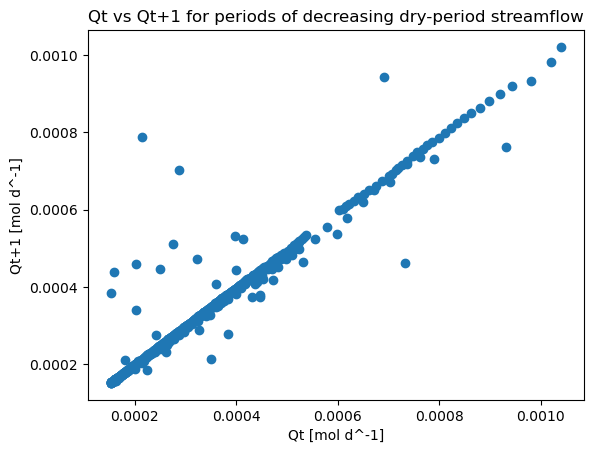

In [65]:
plt.scatter(filtered_gw_df['Qt'], filtered_gw_df['Qt_plus_1'])
plt.xlabel('Qt [mol d^-1]')
plt.ylabel('Qt+1 [mol d^-1]')
plt.title('Qt vs Qt+1 for periods of decreasing dry-period streamflow')
# plt.savefig('recession analysis', dpi=1000)
plt.show()

In [66]:
X_gw = filtered_gw_df['Qt'].values.reshape(-1, 1)
y_gw = filtered_gw_df['Qt_plus_1'].values

In [67]:
reg_gw = LinearRegression(fit_intercept=False)
reg_gw.fit(X_gw, y_gw)
recession_constant_a_gw = reg_gw.coef_[0]
print(f"recession constant: {recession_constant_a_gw}")

recession constant: 0.9881641114040819


## calculating BFImax using LH method:

In [68]:
df_BFI = pd.read_csv('../numerical method/base_calibrated-wb-2014_2022-GW.csv', comment='#', index_col=0)
df_BFI.index = pd.to_datetime(df_BFI.index)
df_BFI = df_BFI[df_BFI.index >= '2015-10-01']
df_BFI['watershed boundary discharge [m^3/s]'] = df_BFI['watershed boundary discharge [m^3/d]'] / 86400
series = df_BFI['watershed boundary discharge [m^3/s]']

if not isinstance(series.index, pd.DatetimeIndex):
    series.index = pd.to_datetime(series.index)

Q, date = clean_streamflow(series)

a=recession_constant_a_gw


b_LH = LH(Q)


BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)

print(f"BFImax: {BFImax}")

BFImax: 0.763


In [69]:
def EK_baseflow(strflow):
    
    print ("Baseflow Separation Method 2 - Execution started")
    
    alpha=recession_constant_a_gw
    BFI_max = BFImax
    flow = np.array(strflow)
    BFlow = np.zeros([len(flow)])
    BFlow[0] = flow[0]
    for i in range(1,len(flow)):
    # algorithm
            BFlow[i] = ((1 - BFI_max) * alpha * BFlow[i-1] + (1 - alpha) * BFI_max * flow[i]) / (1 - alpha * BFI_max)
            if BFlow[i] > flow[i]:
                BFlow[i] = flow[i]
    print ("Baseflow Separation Method 2 - Execution completed successfully \n")
    return(BFlow)

In [70]:
df_BFI['Total_Runoff_cfs'] = df_BFI['watershed boundary discharge [m^3/d]'] * (3.28084**3) / (24*60*60)  # convert to cfs
new_df = df_BFI[['Total_Runoff_cfs']]

strflow = new_df

In [71]:
strflow['EK_baseflow'] = EK_baseflow(strflow['Total_Runoff_cfs'].values)

Baseflow Separation Method 2 - Execution started
Baseflow Separation Method 2 - Execution completed successfully 



C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\2691859698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strflow['EK_baseflow'] = EK_baseflow(strflow['Total_Runoff_cfs'].values)


In [72]:
conversion_factor = 0.0283168
strflow['EK_baseflow_cms']=strflow['EK_baseflow']*conversion_factor
strflow['Total_Runoff_cms']=strflow['Total_Runoff_cfs']*conversion_factor

C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\2650263010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strflow['EK_baseflow_cms']=strflow['EK_baseflow']*conversion_factor
C:\Users\jihad\AppData\Local\Temp\ipykernel_12060\2650263010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strflow['Total_Runoff_cms']=strflow['Total_Runoff_cfs']*conversion_factor


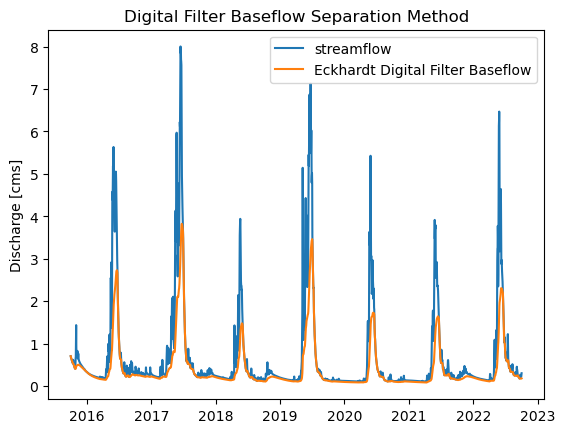

In [73]:
plt.figure()  

plt.plot(strflow.index, strflow['Total_Runoff_cms'], label='streamflow')
plt.plot(strflow.index, strflow['EK_baseflow_cms'], label='Eckhardt Digital Filter Baseflow')
plt.legend()
plt.title('Digital Filter Baseflow Separation Method')
plt.savefig('Digital Filter Baseflow Separation Method', dpi=1200)
plt.ylabel('Discharge [cms]')
plt.show()

# Adding the UKIH:

In [74]:
UKIH_streamflow = pd.read_csv('../numerical method/base_calibrated-wb-2014_2022-GW.csv', comment='#', index_col=0)


In [75]:
UKIH_streamflow['watershed boundary discharge [m^3/s]'] = UKIH_streamflow['watershed boundary discharge [m^3/d]'] / 86400
UKIH_streamflow = UKIH_streamflow[['watershed boundary discharge [m^3/s]']]

In [76]:
UKIH_sep = baseflow.separation(UKIH_streamflow)

100%|██████████| 1/1 [00:18<00:00, 18.98s/it]


In [77]:
bf_ukih = UKIH_sep['UKIH']

In [78]:
UKIH_streamflow = UKIH_streamflow[UKIH_streamflow.index >= '2015-10-01']
bf_ukih = bf_ukih[bf_ukih.index >= '2015-10-01']

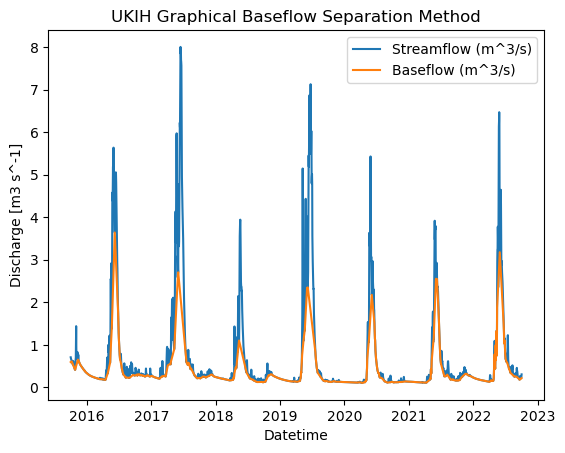

In [79]:
plt.figure()

plt.plot(UKIH_streamflow.index, UKIH_streamflow['watershed boundary discharge [m^3/s]'], label='Streamflow (m^3/s)')
plt.plot(bf_ukih.index, bf_ukih['watershed boundary discharge [m^3/s]'], label='Baseflow (m^3/s)')

# Adding labels and title
plt.xlabel('Datetime')
plt.ylabel('Discharge [m3 s^-1]')
plt.title('UKIH Graphical Baseflow Separation Method')
# Adding legend
plt.legend()
# plt.savefig('UKIH Graphical Baseflow Separation Method.png', dpi = 1200)
plt.show()

In [80]:
startdate = '2021-01-01'
enddate = '2022-01-01'
filtered_UKIH_streamflow = UKIH_streamflow[(UKIH_streamflow.index >= startdate) & (UKIH_streamflow.index <= enddate)]
filtered_bf_ukih = bf_ukih[(bf_ukih.index >= startdate) & (bf_ukih.index <= enddate)]

max_value = filtered_bf_ukih.max()
max_date = filtered_bf_ukih.idxmax()
print("Maximum value:", max_value)
print("Date of maximum value:", max_date)

Maximum value: watershed boundary discharge [m^3/s]    2.553179
dtype: float64
Date of maximum value: watershed boundary discharge [m^3/s]   2021-06-03
dtype: datetime64[ns]


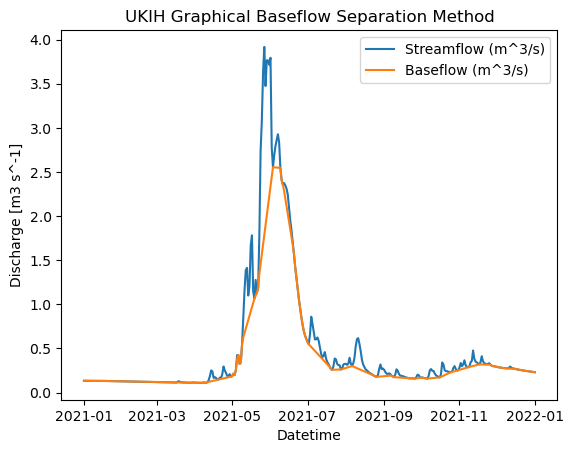

In [81]:
plt.figure()

plt.plot(filtered_UKIH_streamflow.index, filtered_UKIH_streamflow['watershed boundary discharge [m^3/s]'], label='Streamflow (m^3/s)')
plt.plot(filtered_bf_ukih.index, filtered_bf_ukih['watershed boundary discharge [m^3/s]'], label='Baseflow (m^3/s)')

# Adding labels and title
plt.xlabel('Datetime')
plt.ylabel('Discharge [m3 s^-1]')
plt.title('UKIH Graphical Baseflow Separation Method')
# Adding legend
plt.legend()
# plt.savefig('UKIH Graphical Baseflow Separation Method_zoom.png', dpi = 1200)
plt.show()

In [82]:
combined_df = pd.DataFrame({
    'MCB_baseflow_power': merged_df['MCB_baseflow_power'],
    'EK_baseflow_cms': strflow['EK_baseflow_cms'],
    'final_baseflow': df['final_baseflow [m3 s^-1]'],
    'streamflow': df['net runoff [m3 s^-1]'],
    'UKIH_baseflow': bf_ukih['watershed boundary discharge [m^3/s]']
})

# Sensitivity test of Digital Filter Method: 

In [83]:
xie_baseflow = pd.read_csv('../numerical method/base_calibrated-wb-2014_2022-GW.csv', comment='#', index_col=0)
xie_baseflow['watershed boundary discharge [m^3/s]'] = xie_baseflow['watershed boundary discharge [m^3/d]'] / 86400

In [84]:
if not isinstance(xie_baseflow.index, pd.DatetimeIndex):
    xie_baseflow.index = pd.to_datetime(xie_baseflow.index)


def clean_streamflow(series):

    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")
    
    date = series.index
    Q = series.values.astype(float)
    
    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])
    
    year_unique, counts = np.unique(date.year, return_counts=True)
    keep = np.isin(date.year, year_unique[counts >= 120])
    
    return Q[keep], date[keep]

a=recession_constant_a_gw
BFImax_8=0.663
area=20.4
ice = None

In [85]:
def single(series, area=area, ice=None, method='all', return_kge=False):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    # if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
    #     ice = exist_ice(date, ice)
    # strict = strict_baseflow(Q, ice)
    # if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
    #     a = recession_coefficient(Q, strict)

    b_LH = LH(Q)
    b8 = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b8[m] = UKIH(Q, b_LH)

        if m == 'Local':
            b8[m] = Local(Q, b_LH, area)

        if m == 'Fixed':
            b8[m] = Fixed(Q, area)

        if m == 'Slide':
            b8[m] = Slide(Q, area)

        if m == 'LH':
            b8[m] = b_LH

        # if m == 'Chapman':
        #     b[m] = Chapman(Q, b_LH, a)

        # if m == 'CM':
        #     b[m] = CM(Q, b_LH, a)

        # if m == 'Boughton':
        #     C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), Boughton, Q, b_LH, a)
        #     b[m] = Boughton(Q, b_LH, a, C)

        # if m == 'Furey':
        #     A = param_calibrate(np.arange(0.01, 10, 0.01), Furey, Q, b_LH, a)
        #     b[m] = Furey(Q, b_LH, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            # BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)
            b8[m] = Eckhardt(Q, b_LH, a, BFImax_8)

        # if m == 'EWMA':
        #     e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), EWMA, Q, b_LH, 0)
        #     b[m] = EWMA(Q, b_LH, 0, e)

        # if m == 'Willems':
        #     w = param_calibrate(np.arange(0.001, 1, 0.001), Willems, Q, b_LH, a)
        #     b[m] = Willems(Q, b_LH, a, w)

    # if return_kge:
    #     KGEs = pd.Series(KGE(b[strict].values, np.repeat(
    #         Q[strict], len(method)).reshape(-1, len(method))), index=b.columns)
    #     return b, KGEs
    # else:
    return b8, None

series = xie_baseflow['watershed boundary discharge [m^3/s]']
b8, _ = single(series, area=area, ice=ice, method='all', return_kge=False)

b8 = b8[b8.index >= '2015-10-01']


In [86]:
if not isinstance(xie_baseflow.index, pd.DatetimeIndex):
    xie_baseflow.index = pd.to_datetime(xie_baseflow.index)


def clean_streamflow(series):

    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")
    
    date = series.index
    Q = series.values.astype(float)
    
    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])
    
    year_unique, counts = np.unique(date.year, return_counts=True)
    keep = np.isin(date.year, year_unique[counts >= 120])
    
    return Q[keep], date[keep]


a=recession_constant_a_gw
BFImax_7=0.863
area=20.4
ice = None

In [87]:
def single(series, area=area, ice=None, method='all', return_kge=True):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    # if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
    #     ice = exist_ice(date, ice)
    # strict = strict_baseflow(Q, ice)
    # if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
    #     a = recession_coefficient(Q, strict)

    b_LH = LH(Q)
    b7 = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b7[m] = UKIH(Q, b_LH)

        if m == 'Local':
            b7[m] = Local(Q, b_LH, area)

        if m == 'Fixed':
            b7[m] = Fixed(Q, area)

        if m == 'Slide':
            b7[m] = Slide(Q, area)

        if m == 'LH':
            b7[m] = b_LH

        # if m == 'Chapman':
        #     b[m] = Chapman(Q, b_LH, a)

        # if m == 'CM':
        #     b[m] = CM(Q, b_LH, a)

        # if m == 'Boughton':
        #     C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), Boughton, Q, b_LH, a)
        #     b[m] = Boughton(Q, b_LH, a, C)

        # if m == 'Furey':
        #     A = param_calibrate(np.arange(0.01, 10, 0.01), Furey, Q, b_LH, a)
        #     b[m] = Furey(Q, b_LH, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            # BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)
            b7[m] = Eckhardt(Q, b_LH, a, BFImax_7)

        # if m == 'EWMA':
        #     e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), EWMA, Q, b_LH, 0)
        #     b[m] = EWMA(Q, b_LH, 0, e)

        # if m == 'Willems':
        #     w = param_calibrate(np.arange(0.001, 1, 0.001), Willems, Q, b_LH, a)
        #     b[m] = Willems(Q, b_LH, a, w)

    # if return_kge:
    #     KGEs = pd.Series(KGE(b[strict].values, np.repeat(
    #         Q[strict], len(method)).reshape(-1, len(method))), index=b.columns)
    #     return b, KGEs
    # else:
    return b7, None

series = xie_baseflow['watershed boundary discharge [m^3/s]']
b7, _ = single(series, area=area, ice=ice, method='all', return_kge=False)

b7 = b7[b7.index >= '2015-10-01']

In [88]:
if not isinstance(xie_baseflow.index, pd.DatetimeIndex):
    xie_baseflow.index = pd.to_datetime(xie_baseflow.index)


def clean_streamflow(series):

    if not isinstance(series, pd.Series):
        raise ValueError("Input must be a pandas Series")
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DateTimeIndex")
    
    date = series.index
    Q = series.values.astype(float)
    
    has_value = np.isfinite(Q)
    date = date[has_value]
    Q = np.abs(Q[has_value])
    
    year_unique, counts = np.unique(date.year, return_counts=True)
    keep = np.isin(date.year, year_unique[counts >= 120])
    
    return Q[keep], date[keep]

a=recession_constant_a_gw
BFImax=BFImax
area=20.4
ice = None
BFImax

0.763

In [89]:
def single(series, area=area, ice=None, method='all', return_kge=True):
    Q, date = clean_streamflow(series)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    # if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
    #     ice = exist_ice(date, ice)
    # strict = strict_baseflow(Q, ice)
    # if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
    #     a = recession_coefficient(Q, strict)

    b_LH = LH(Q)
    b = pd.DataFrame(np.nan, index=date, columns=method)
    for m in method:
        if m == 'UKIH':
            b[m] = UKIH(Q, b_LH)

        if m == 'Local':
            b[m] = Local(Q, b_LH, area)

        if m == 'Fixed':
            b[m] = Fixed(Q, area)

        if m == 'Slide':
            b[m] = Slide(Q, area)

        if m == 'LH':
            b[m] = b_LH

        # if m == 'Chapman':
        #     b[m] = Chapman(Q, b_LH, a)

        # if m == 'CM':
        #     b[m] = CM(Q, b_LH, a)

        # if m == 'Boughton':
        #     C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), Boughton, Q, b_LH, a)
        #     b[m] = Boughton(Q, b_LH, a, C)

        # if m == 'Furey':
        #     A = param_calibrate(np.arange(0.01, 10, 0.01), Furey, Q, b_LH, a)
        #     b[m] = Furey(Q, b_LH, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            # BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)
            b[m] = Eckhardt(Q, b_LH, a, BFImax)

        # if m == 'EWMA':
        #     e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), EWMA, Q, b_LH, 0)
        #     b[m] = EWMA(Q, b_LH, 0, e)

        # if m == 'Willems':
        #     w = param_calibrate(np.arange(0.001, 1, 0.001), Willems, Q, b_LH, a)
        #     b[m] = Willems(Q, b_LH, a, w)

    # if return_kge:
    #     KGEs = pd.Series(KGE(b[strict].values, np.repeat(
    #         Q[strict], len(method)).reshape(-1, len(method))), index=b.columns)
    #     return b, KGEs
    # else:
    return b, None
series = xie_baseflow['watershed boundary discharge [m^3/s]']
b, _ = single(series, area=area, ice=ice, method='all', return_kge=False)

b = b[b.index >= '2015-10-01']

In [90]:
start_date = pd.Timestamp('2015-10-01')
filtered_xie_baseflow = xie_baseflow.loc[start_date:]

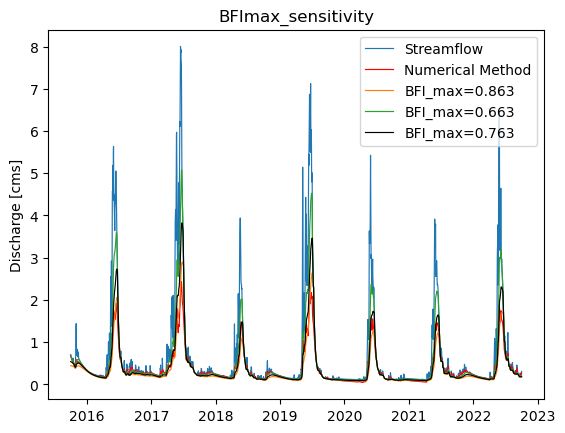

In [91]:
plt.figure()  

plt.plot(filtered_xie_baseflow.index, filtered_xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow', linewidth=0.85)
plt.plot(combined_df.index, combined_df['final_baseflow'], label='Numerical Method',color = 'red', linewidth=0.85)

plt.plot(b8.index, b8['Eckhardt'], label='BFI_max=0.863', linewidth=0.85)
plt.plot(b7.index, b7['Eckhardt'], label='BFI_max=0.663', linewidth=0.85)
plt.plot(b.index, b['Eckhardt'], label='BFI_max=0.763', linewidth=0.85, color='black')

plt.legend()
plt.title('BFImax_sensitivity')
plt.ylabel('Discharge [cms]')
# plt.savefig('BFImax_sensitivity', dpi=1200)
plt.show()

In [92]:
startdate = '2016-05-01'
enddate = '2016-10-01'
filtered_xie_baseflow  = xie_baseflow.loc[startdate:enddate]
b8  = b8.loc[startdate:enddate]
b7  = b7.loc[startdate:enddate]
b_org  = b.loc[startdate:enddate]
filt_combined_df=combined_df.loc[startdate:enddate]

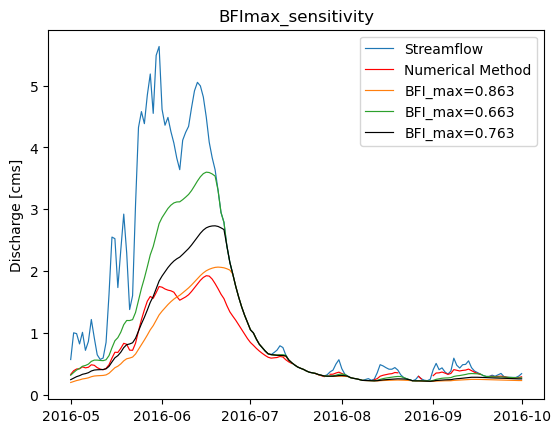

In [93]:
plt.figure()  

plt.plot(filtered_xie_baseflow.index, filtered_xie_baseflow['watershed boundary discharge [m^3/s]'], label='Streamflow', linewidth=0.85)
plt.plot(filt_combined_df.index, filt_combined_df['final_baseflow'], label='Numerical Method',color = 'red', linewidth=0.85)

plt.plot(b8.index, b8['Eckhardt'], label='BFI_max=0.863', linewidth=0.85)
plt.plot(b7.index, b7['Eckhardt'], label='BFI_max=0.663', linewidth=0.85)
plt.plot(b_org.index, b_org['Eckhardt'], label='BFI_max=0.763', linewidth=0.85, color='black')

plt.legend()
plt.title('BFImax_sensitivity')
plt.ylabel('Discharge [cms]')
# plt.savefig('BFI_max Sensitivity Test', dpi=1200)
plt.show()

In [94]:
import numpy as np

# Convert the time index to a numerical value in seconds (if it is in datetime format)
time_step_seconds = (filtered_xie_baseflow.index[1] - filtered_xie_baseflow.index[0]).total_seconds()

# Calculate the total volume for each dataset
volume_streamflow = np.trapz(filtered_xie_baseflow['watershed boundary discharge [m^3/s]'], dx=time_step_seconds)
volume_b8 = np.trapz(b8['Eckhardt'], dx=time_step_seconds)
volume_b7 = np.trapz(b7['Eckhardt'], dx=time_step_seconds)
volume_b = np.trapz(b['Eckhardt'], dx=time_step_seconds)

# Store the results in a dictionary
volumes = {
    'Streamflow': volume_streamflow,
    'BFI_max=0.863': volume_b8,
    'BFI_max=0.663': volume_b7,
    'BFI_max=0.763': volume_b
}

# Convert to DataFrame for easier viewing
volumes_df = pd.DataFrame(list(volumes.items()), columns=['Method', 'Total Volume (m^3)'])

# Print the results
print("Total Volumes for Each Method:")
print(volumes_df)


Total Volumes for Each Method:
          Method  Total Volume (m^3)
0     Streamflow        1.858048e+07
1  BFI_max=0.863        8.622829e+06
2  BFI_max=0.663        1.312447e+07
3  BFI_max=0.763        9.285201e+07


In [95]:
combined_df['UKIH_xie_[m^3/s]']=b['UKIH']
combined_df['Local_xie_[m^3/s]']=b['Local']
combined_df['Fixed_xie_[m^3/s]']=b['Fixed']
combined_df['Slide_xie_[m^3/s]']=b['Slide']
combined_df['Eckhardt_xie_[m^3/s]']=b['Eckhardt']

## plotting the LocMin baseflow: 

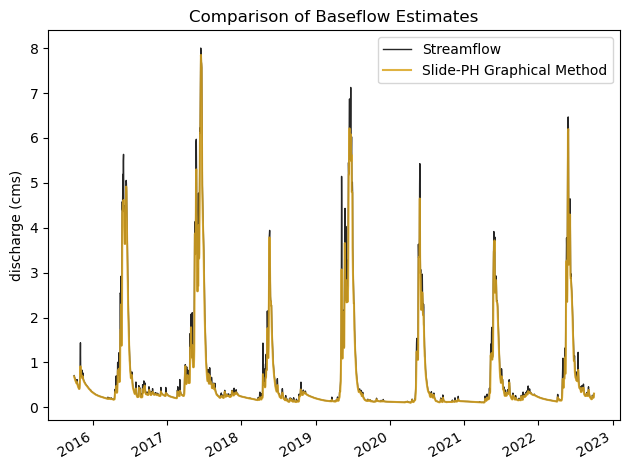

In [96]:
fig, ax = plt.subplots()


ax.plot(combined_df.index, combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)
ax.plot(combined_df.index, combined_df['Slide_xie_[m^3/s]'], label='Slide-PH Graphical Method', alpha=0.85, color='#DAA520')

ax.set_title('Comparison of Baseflow Estimates')
ax.set_ylabel('discharge (cms)')

plt.gcf().autofmt_xdate()
plt.tight_layout()
ax.legend()

plt.savefig('Slide-PH Graphical Method.png', dpi=1200)

plt.show()

In [97]:
startdate = '2016-04-01'
enddate = '2016-09-01'
PH_combined_df = combined_df.loc[startdate:enddate]

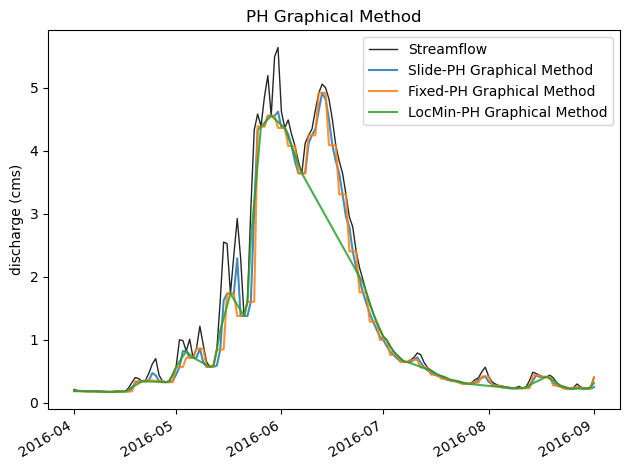

In [98]:
fig, ax = plt.subplots()


ax.plot(PH_combined_df.index, PH_combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)
ax.plot(PH_combined_df.index, PH_combined_df['Slide_xie_[m^3/s]'], label='Slide-PH Graphical Method', alpha=0.85)
ax.plot(PH_combined_df.index, PH_combined_df['Fixed_xie_[m^3/s]'], label='Fixed-PH Graphical Method', alpha=0.85)
ax.plot(PH_combined_df.index, PH_combined_df['Local_xie_[m^3/s]'], label='LocMin-PH Graphical Method', alpha=0.85)


ax.set_title('PH Graphical Method')
ax.set_ylabel('discharge (cms)')

plt.gcf().autofmt_xdate()
plt.tight_layout()
ax.legend()

plt.savefig('PH Graphical Method.png', dpi=1200)

plt.show()

# plot all the baseflow from numerical model, UKIH, HYSEP graphical, digital, numerical, and mass balance method:

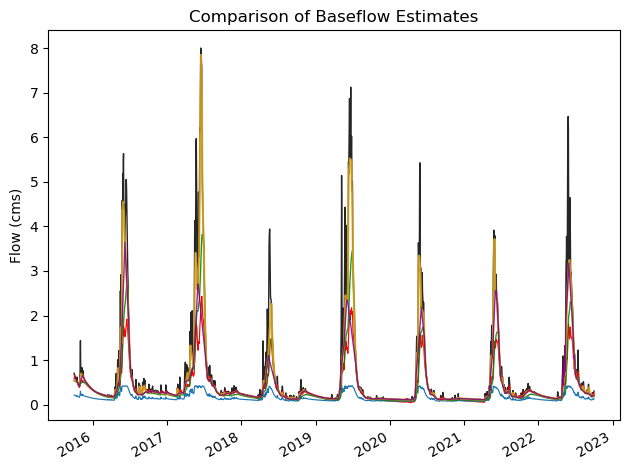

In [99]:
fig, ax = plt.subplots()


ax.plot(combined_df.index, combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)

ax.plot(combined_df.index, combined_df['final_baseflow'], label='Integrated Hydrologic Method',color = 'red', linewidth=0.85)

ax.plot(combined_df.index, combined_df['MCB_baseflow_power'], label='Conductance Mass Balance Method', linewidth=0.85)

# ax.plot(combined_df.index, combined_df['EK_baseflow_cms'], label='Eckhardt Digital Filter Method', linewidth=1, color='blue',alpha = 0.85)

ax.plot(combined_df.index, combined_df['Eckhardt_xie_[m^3/s]'], label='Eckhardt Digital Filter Method', linewidth=1, color='green', alpha=0.85)


# ax.plot(combined_df.index, combined_df['hydrograph_py'], label='Hewlett-Graphical Method', linewidth=1, alpha = 0.85)

# ax.plot(combined_df.index, combined_df['LocMin'], label='LocMin-Pettyjohn Graphical Method', linewidth=1,alpha = 0.85,color='#DAA520')
ax.plot(combined_df.index, combined_df['Local_xie_[m^3/s]'], label='LocMin Graphical Method', alpha=0.85, color='#DAA520')

# ax.plot(combined_df.index, combined_df['UKIH'], label='UKIH Graphical Method', linewidth=1,alpha = 0.85, color = 'purple')
ax.plot(combined_df.index, combined_df['UKIH_xie_[m^3/s]'], label='UKIH Graphical Method', linewidth=1,alpha = 0.85, color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates')
ax.set_ylabel('Flow (cms)')



# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('Comparison_of_Baseflow_separation_final.png', dpi=1200)

plt.show()

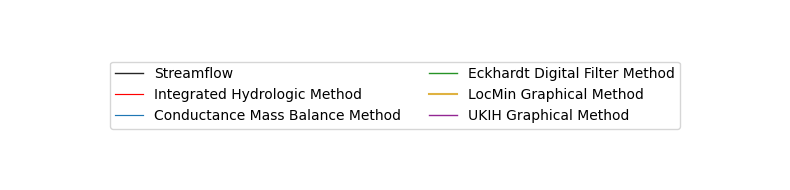

In [100]:
fig_legend = plt.figure(figsize=(8, 2))
ax_legend = fig_legend.add_subplot(111)
fig_legend.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
ax_legend.axis('off')
plt.tight_layout()
fig_legend.savefig('Comparison_of_Baseflow_Legend.png', dpi=1200, bbox_inches='tight')

plt.show()

In [101]:
startdate = '2017-02-01'
enddate = '2017-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

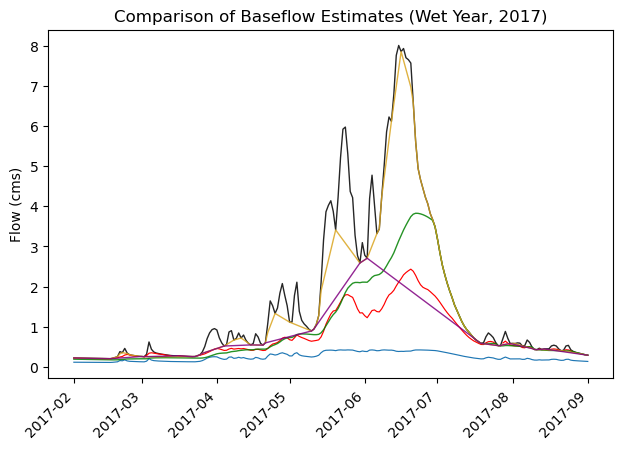

In [102]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)

# Plot baseflow from BFI 0.7

# Plot simulated baseflow
ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Method', color='red', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['MCB_baseflow_power'], label='Conductance Mass Balance Method', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_xie_[m^3/s]'], label='Eckhardt Digital Filter Method', linewidth=1, color='green', alpha=0.85)
# ax.plot(filtered_combined_df.index, filtered_combined_df['hydrograph_py'], label='Hewlett-Graphical Method', linewidth=1, alpha=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_xie_[m^3/s]'], label='LocMin-Pettyjohn Graphical Method', linewidth=1, alpha=0.85, color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH_xie_[m^3/s]'], label='UKIH Graphical Method', linewidth=1,alpha = 0.85, color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Wet Year, 2017)')
ax.set_ylabel('Flow (cms)')
plt.tight_layout()

plt.gcf().autofmt_xdate(rotation=45, ha='right')

plt.savefig('Comparison_of_Baseflow_Estimates_final_wet_2017.png', dpi=1200)

plt.show()

In [103]:
startdate = '2021-02-01'
enddate = '2021-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

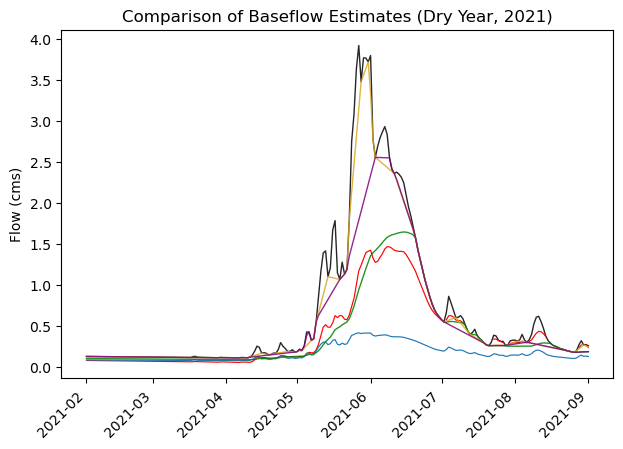

In [104]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)

# Plot baseflow from BFI 0.7

# Plot simulated baseflow
ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Method', color='red', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['MCB_baseflow_power'], label='Conductance Mass Balance Method', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_xie_[m^3/s]'], label='Eckhardt Digital Filter Method', linewidth=1, color='green', alpha=0.85)
# ax.plot(filtered_combined_df.index, filtered_combined_df['hydrograph_py'], label='Hewlett-Graphical Method', linewidth=1, alpha=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_xie_[m^3/s]'], label='LocMin-Pettyjohn Graphical Method', linewidth=1, alpha=0.85, color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH_xie_[m^3/s]'], label='UKIH Graphical Method', linewidth=1,alpha = 0.85, color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Dry Year, 2021)')
ax.set_ylabel('Flow (cms)')
plt.tight_layout()

plt.gcf().autofmt_xdate(rotation=45, ha='right')

plt.savefig('Comparison_of_Baseflow_Estimates_final_zoom_dry_2021.png', dpi=1200)

plt.show()

In [105]:
startdate = '2016-02-01'
enddate = '2016-09-01'
filtered_combined_df = combined_df.loc[startdate:enddate]

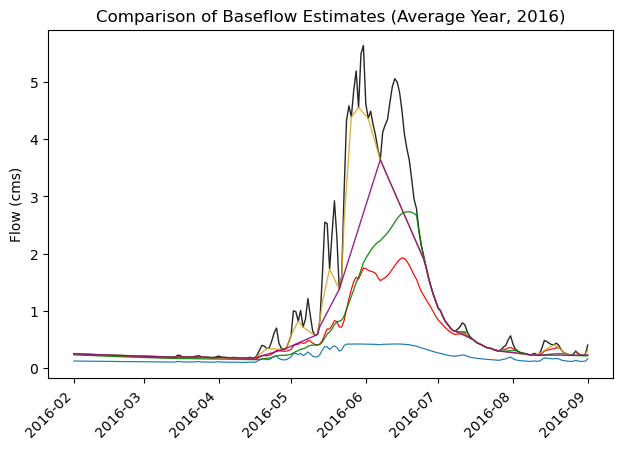

In [106]:
fig, ax = plt.subplots()

ax.plot(filtered_combined_df.index, filtered_combined_df['streamflow'], label='Streamflow', linewidth=1, color='black', alpha=0.85)

# Plot baseflow from BFI 0.7

# Plot simulated baseflow
ax.plot(filtered_combined_df.index, filtered_combined_df['final_baseflow'], label='Integrated Hydrologic Method', color='red', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['MCB_baseflow_power'], label='Conductance Mass Balance Method', linewidth=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Eckhardt_xie_[m^3/s]'], label='Eckhardt Digital Filter Method', linewidth=1, color='green', alpha=0.85)
# ax.plot(filtered_combined_df.index, filtered_combined_df['hydrograph_py'], label='Hewlett-Graphical Method', linewidth=1, alpha=0.85)
ax.plot(filtered_combined_df.index, filtered_combined_df['Local_xie_[m^3/s]'], label='LocMin-Pettyjohn Graphical Method', linewidth=1, alpha=0.85, color='#DAA520')
ax.plot(filtered_combined_df.index, filtered_combined_df['UKIH_xie_[m^3/s]'], label='UKIH Graphical Method', linewidth=1,alpha = 0.85, color = 'purple')

# Set the plot title and labels
ax.set_title('Comparison of Baseflow Estimates (Average Year, 2016)')
ax.set_ylabel('Flow (cms)')
plt.tight_layout()

plt.gcf().autofmt_xdate(rotation=45, ha='right')

plt.savefig('Comparison_of_Baseflow_Estimates_final_zoom_avg_2016.png', dpi=1200)

plt.show()

## find the stats of each method in addition to the RMSE with the integrated model

In [107]:
start_date = '2015-10-01'
end_date = '2022-10-01'
combined_df = combined_df.loc[start_date:end_date]

In [108]:
# start_date = '2021-10-01'
# end_date = '2022-10-01'
# combined_df_new = combined_df.loc[start_date:end_date]

mKGE: 0.25427874703336917, cc:  0.9424262712251869, alpha:  0.5437784951494733, beta:  0.4129332308902105


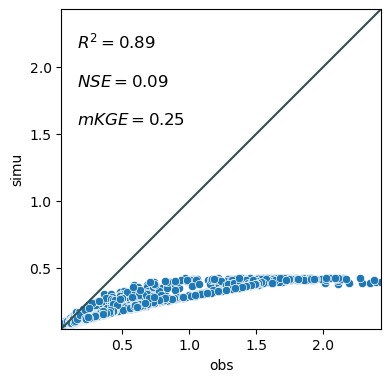

In [109]:
gp.one2one_plot(combined_df['final_baseflow'], combined_df['MCB_baseflow_power'],
               metrics=['R^2', 'NSE', 'mKGE'],
                # metrics='all',
               show_density=False,
                start_date="2015-10-01",
                decompose_KGE=True
               )

plt.tight_layout()
plt.savefig('simu_obs_statistics_MCB')

mKGE: 0.6818258297732663, cc:  0.9644544419034864, alpha:  1.2994707886157508, beta:  1.1014325522943111


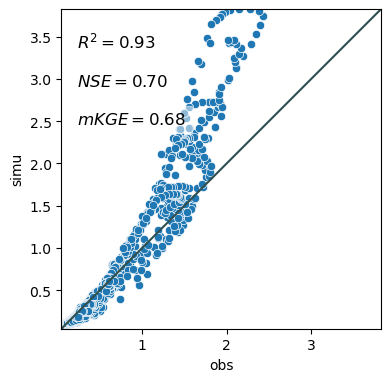

In [110]:
gp.one2one_plot(combined_df['final_baseflow'], combined_df['Eckhardt_xie_[m^3/s]'],
               metrics=['R^2', 'NSE', 'mKGE'],
                # metrics='all',
               show_density=False,
                start_date="2015-10-01",
                decompose_KGE=True
               )

plt.tight_layout()
plt.savefig('simu_obs_statistics_digital')

mKGE: 0.2636054481328076, cc:  0.9360166827273987, alpha:  1.4874926758469187, beta:  1.5482097793054113


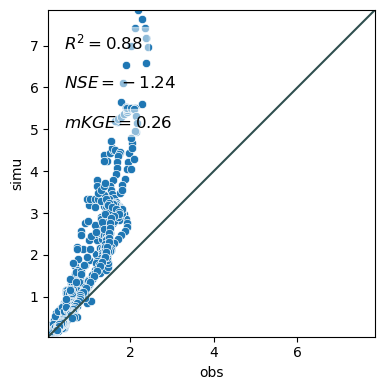

In [111]:
gp.one2one_plot(combined_df['final_baseflow'], combined_df['Local_xie_[m^3/s]'],
               metrics=['R^2', 'NSE', 'mKGE'],
                # metrics='all',
               show_density=False,
                start_date="2015-10-01",
                decompose_KGE=True
               )

plt.tight_layout()
plt.savefig('simu_obs_statistics_graphical')

mKGE: 0.7245118908632706, cc:  0.9206117284157079, alpha:  1.1569550592319586, beta:  1.2120290310124573


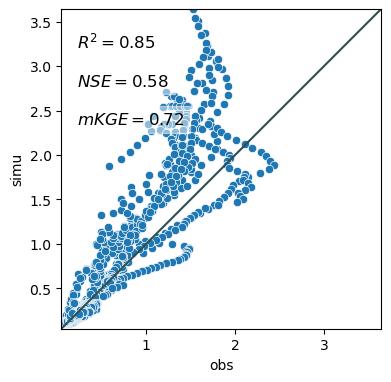

In [112]:
gp.one2one_plot(combined_df['final_baseflow'], combined_df['UKIH_xie_[m^3/s]'],
               metrics=['R^2', 'NSE', 'mKGE'],
                # metrics='all',
               show_density=False,
                start_date="2015-10-01",
                decompose_KGE=True
               )

plt.tight_layout()
plt.savefig('simu_obs_statistics_graphical')

In [113]:
start_date = '2015-10-01'
end_date = '2022-10-01'
combined_df = combined_df.loc[start_date:end_date]

In [114]:
methods = ['final_baseflow', 'MCB_baseflow_power', 'Eckhardt_xie_[m^3/s]', 'Local_xie_[m^3/s]', 'UKIH_xie_[m^3/s]']
stats = pd.DataFrame(index=['Min', 'Max', 'Mean', 'Std Dev', 'Total Volume'])
time_step_seconds = 86400

In [115]:
for method in methods:
    total_volume = combined_df[method].sum() * time_step_seconds
    stats[method] = [
        combined_df[method].min(),
        combined_df[method].max(),
        combined_df[method].mean(),
        combined_df[method].std(),
        total_volume
    ]

In [116]:
integrated_method = combined_df['final_baseflow']
rmse = {}

for method in methods:
    if method != 'final_baseflow':
        rmse[method] = np.sqrt(np.mean((combined_df[method] - integrated_method) ** 2))

rmse_df = pd.DataFrame(list(rmse.items()), columns=['Method', 'RMSE'])

print("Baseflow Statistics:")
print(stats)
print("\nRMSE Values:")
print(rmse_df)

Baseflow Statistics:
              final_baseflow  MCB_baseflow_power  Eckhardt_xie_[m^3/s]  \
Min             4.546173e-02        7.419500e-02          8.776403e-02   
Max             2.432346e+00        4.222725e-01          3.824428e+00   
Mean            4.012933e-01        1.611414e-01          4.205215e-01   
Std Dev         4.408600e-01        9.461915e-02          5.989550e-01   
Total Volume    7.877419e+07        3.558622e+07          9.286730e+07   

              Local_xie_[m^3/s]  UKIH_xie_[m^3/s]  
Min                1.048807e-01      1.048807e-01  
Max                7.848510e+00      3.640668e+00  
Mean               5.803953e-01      4.599847e-01  
Std Dev            9.647001e-01      5.884949e-01  
Total Volume       1.281736e+08      1.015823e+08  

RMSE Values:
                 Method      RMSE
0    MCB_baseflow_power  0.421124
1  Eckhardt_xie_[m^3/s]  0.239915
2     Local_xie_[m^3/s]  0.659894
3      UKIH_xie_[m^3/s]  0.286234


In [117]:
total_volume_discharge = combined_df['streamflow'].sum() * time_step_seconds
discharge_stats = {
    'Min': combined_df['streamflow'].min(),
    'Max': combined_df['streamflow'].max(),
    'Mean': combined_df['streamflow'].mean(),
    'Std Dev': combined_df['streamflow'].std(),
    'Total Volume': total_volume_discharge
}
stats['streamflow'] = discharge_stats

In [118]:
stats

,final_baseflow,MCB_baseflow_power,Eckhardt_xie_[m^3/s],Local_xie_[m^3/s],UKIH_xie_[m^3/s],streamflow
Min,4.546173e-02,7.419500e-02,8.776403e-02,1.048807e-01,1.048807e-01,1.048807e-01
Max,2.432346e+00,4.222725e-01,3.824428e+00,7.848510e+00,3.640668e+00,8.002213e+00
Mean,4.012933e-01,1.611414e-01,4.205215e-01,5.803953e-01,4.599847e-01,6.795195e-01
Std Dev,4.408600e-01,9.461915e-02,5.989550e-01,9.647001e-01,5.884949e-01,1.155946e+00
Total Volume,7.877419e+07,3.558622e+07,9.286730e+07,1.281736e+08,1.015823e+08,1.500640e+08


In [119]:
from hydroeval import evaluator, nse, kge

In [120]:
time_step_seconds = 86400

def calculate_total_volume(series, time_step):
    return series.sum() * time_step

water_years_baseflow = combined_df['UKIH_xie_[m^3/s]'].resample('A-SEP')
water_years_streamflow = combined_df['streamflow'].resample('A-SEP')

water_year_volumes_list = []



In [121]:
for (water_year_baseflow, baseflow_data), (water_year_streamflow, streamflow_data) in zip(water_years_baseflow, water_years_streamflow):
    baseflow_volume = calculate_total_volume(baseflow_data, time_step_seconds)
    streamflow_volume = calculate_total_volume(streamflow_data, time_step_seconds)
    percentage_baseflow = (baseflow_volume / streamflow_volume) * 100 if streamflow_volume != 0 else 0
    water_year_volumes_list.append({
        'Water Year': water_year_baseflow.year,
        'Baseflow Volume': baseflow_volume,
        'Streamflow Volume': streamflow_volume,
        'Percentage Baseflow': percentage_baseflow
    })

water_year_volumes = pd.DataFrame(water_year_volumes_list)

In [122]:
water_year_volumes

,Water Year,Baseflow Volume,Streamflow Volume,Percentage Baseflow
0,2016,1.908960e+07,2.555877e+07,74.689064
1,2017,1.898916e+07,3.358122e+07,56.546960
2,2018,9.421710e+06,1.420763e+07,66.314434
3,2019,1.564118e+07,2.785280e+07,56.156587
4,2020,1.043306e+07,1.406104e+07,74.198348
5,2021,1.172065e+07,1.429960e+07,81.964858
6,2022,1.626871e+07,2.047851e+07,79.442821
7,2023,1.820526e+04,2.441734e+04,74.558718


In [123]:
methods = ['final_baseflow', 'MCB_baseflow_power', 'Eckhardt_xie_[m^3/s]', 'Local_xie_[m^3/s]', 'UKIH_xie_[m^3/s]']
yearly_volumes_list = []

In [124]:
for method in methods:
    method_water_years = combined_df[method].resample('A-SEP')
    watershed_discharge_water_years = combined_df['streamflow'].resample('A-SEP')
    
    # Calculate the total volume for each water year and compute baseflow index
    for water_year, method_data in method_water_years:
        total_volume_method = calculate_total_volume(method_data, time_step_seconds)
        
        watershed_discharge_data = watershed_discharge_water_years.get_group(water_year)
        total_volume_watershed_discharge = calculate_total_volume(watershed_discharge_data, time_step_seconds)
        
        baseflow_index = (total_volume_method / total_volume_watershed_discharge) * 100
        
        yearly_volumes_list.append({
            'Water Year': water_year.year,
            'Method': method,
            'Total Volume Method (m³)': total_volume_method,
            'Total Volume Watershed Discharge (m³)': total_volume_watershed_discharge,
            'Baseflow Index (%)': baseflow_index
        })

# Create DataFrame from the list
yearly_volumes_df = pd.DataFrame(yearly_volumes_list)


In [125]:
yearly_volumes_df

,Water Year,Method,Total Volume Method (m³),Total Volume Watershed Discharge (m³),Baseflow Index (%)
0,2016,final_baseflow,1.446429e+07,2.555877e+07,56.592299
1,2017,final_baseflow,1.664233e+07,3.358122e+07,49.558439
2,2018,final_baseflow,8.662730e+06,1.420763e+07,60.972373
3,2019,final_baseflow,1.304052e+07,2.785280e+07,46.819438
4,2020,final_baseflow,7.245906e+06,1.406104e+07,51.531788
5,2021,final_baseflow,7.530317e+06,1.429960e+07,52.661034
6,2022,final_baseflow,1.116684e+07,2.047851e+07,54.529568
7,2023,final_baseflow,2.124435e+04,2.441734e+04,87.005193
8,2016,MCB_baseflow_power,5.938369e+06,2.555877e+07,23.234178
9,2017,MCB_baseflow_power,6.264462e+06,3.358122e+07,18.654658


In [126]:
methods = ['final_baseflow', 'MCB_baseflow_power', 'Eckhardt_xie_[m^3/s]', 'Local_xie_[m^3/s]', 'UKIH_xie_[m^3/s]']